In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import torch 
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from typing import Callable
from tqdm import tqdm
from timeit import default_timer as timer
from matplotlib import pyplot as plt
from dataclasses import dataclass
from CommonFunctions import *
%matplotlib inline

In [3]:
@dataclass
class LearningParameters:
    batch_size: int = 128
    cpu_count: int = os.cpu_count()
    learning_rate: float = 0.05
    momentum: float = 0.5
    weight_decay: float = 0.001
    epochs: int = 50
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dropout: float = 0.5
    batch_norm: bool = True
params = LearningParameters()

In [4]:
data_transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])
train_data = datasets.MNIST(
    root='./data', train=True, download=True, transform=data_transform, target_transform=None
)
test_data = datasets.MNIST(
    root='./data', train=False, download=True, transform=data_transform, target_transform=None
)
len(train_data), len(test_data)

(60000, 10000)

In [5]:
data_classes = train_data.classes
data_classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

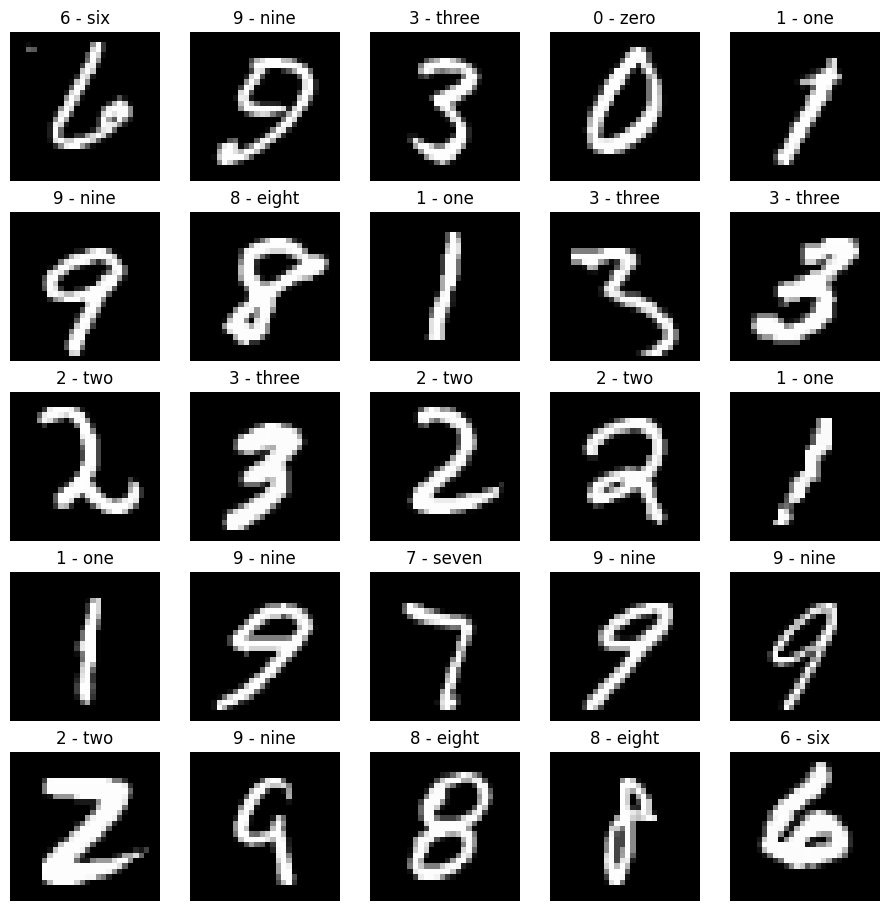

In [6]:
def plot_random_images(dataset, shape, dataset_labels):
    figure, axes = plt.subplots(*shape, layout='constrained', figsize=(9, 9))
    for index, ax in enumerate(figure.axes):
        random_idx = torch.randint(0, len(dataset), size=[1]).item()
        img, lab = dataset[random_idx]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set(title=dataset_labels[lab])
        ax.axis(False)
plot_random_images(train_data, (5, 5), data_classes)

In [7]:
# based on https://www.kaggle.com/code/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1
KERNEL_PARAMS = dict(kernel_size=3, stride=1, padding=1)
class CNN(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=64, **KERNEL_PARAMS),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, **KERNEL_PARAMS),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        ) # shape: (1, 28, 28) -> (64, 14, 14)
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, **KERNEL_PARAMS),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, **KERNEL_PARAMS),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(128)
        ) # shape: (64, 14, 14) -> (128, 7, 7)
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, **KERNEL_PARAMS),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(256)
        ) # shape (128, 7, 7) -> (256, 3, 3)
        self.classifier = nn.Sequential(
            nn.Flatten(), # (256, 3, 3) -> (256*3*3 = 2304)
            nn.Linear(in_features=256*3*3, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=output_shape),
            nn.Softmax(dim=1)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_layer3(self.conv_layer2(self.conv_layer1(x))))

# Data Augmentation

* Random rotation by 10 degrees
* Random zoom by 10 %
* Random shift by 10 % (horizontal and vertical)
* Random shear by 10 %

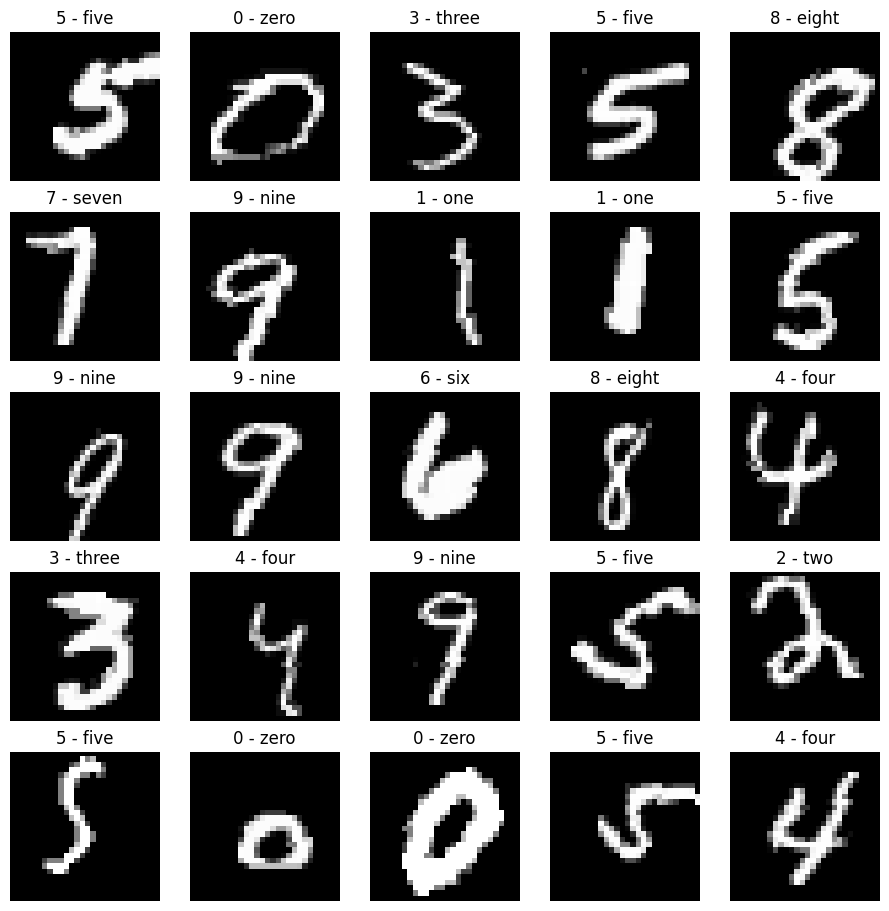

In [8]:
data_transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.RandomAffine(degrees=10,
                            translate=(0.1, 0.1),
                            scale=(1, 1.1),
                            shear=10),
    transforms.ToTensor()
])
train_data = datasets.MNIST(
    root='./data', train=True, download=True, transform=data_transform, target_transform=None
)
plot_random_images(train_data, (5, 5), data_classes)

In [9]:
def train_step(model: nn.Module,
               data_loader: DataLoader,
               loss_function: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_function: Callable,
               device: torch.device = torch.device('cpu')) -> tuple[float:]: 
    train_loss: float = 0
    train_acc: float = 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_function(y, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

def test_step(model: nn.Module,
              data_loader: DataLoader,
              loss_function: nn.Module,
              accuracy_function: Callable,
              device: torch.device = torch.device('cpu')) -> tuple[float:]:
    test_loss: float = 0
    test_acc: float = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_function(test_pred, y).item()
            test_acc += accuracy_function(y, test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    return test_loss, test_acc

def accuracy_fn(y_true, y_pred):
    return (torch.eq(y_true, y_pred).sum().item() / len(y_pred)) * 100

def plot_loss_and_accuracy(title, epochs, train_loss_list, train_acc_list, test_loss_list, test_acc_list):
    with plt.style.context('cyberpunk'):
        figure, axes = plt.subplots(2, 1, layout='constrained', figsize=(8, 6))
        axes[0].plot(range(1, epochs + 1), train_loss_list, 
                     label=f'Train: {train_loss_list[-1]:.2f}')
        axes[0].plot(range(1, epochs + 1), test_loss_list, 
                     label=f'Test: {test_loss_list[-1]:.2f}')
        axes[0].set(ylabel='Loss', title=title)
        axes[0].legend()
        enhance_plot(figure, axes[0], glow=True)
        axes[1].plot(range(1, epochs + 1), train_acc_list, 
                     label=f'Train: {train_acc_list[-1]:.1f}%', zorder=3)
        axes[1].plot(range(1, epochs + 1), test_acc_list, 
                     label=f'Test: {test_acc_list[-1]:.1f}%', zorder=2)
        axes[1].plot([1, params.epochs], [99, 99], color='white', linestyle=':', 
                     label='99%', zorder=1)
        axes[1].set(xlabel='epoch', ylabel='Accuracy')
        axes[1].legend()
        enhance_plot(figure, axes[1], glow=True)
        return figure, axes

In [10]:
loader_kwargs = dict(batch_size=params.batch_size, pin_memory=True, num_workers=params.cpu_count)
train_loader = DataLoader(train_data, **loader_kwargs, shuffle=True)
test_loader = DataLoader(test_data, **loader_kwargs, shuffle=False)
len(train_data), len(test_data), len(train_loader)

(60000, 10000, 469)

In [11]:
modelCNN = CNN(input_shape=1, output_shape=len(data_classes)).to(params.device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    modelCNN.parameters(), lr=params.learning_rate, momentum=params.momentum, weight_decay=params.weight_decay)
modelCNN

CNN(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): B

In [12]:
train_time_start = timer()
train_loss, train_acc = [], []
test_loss, test_acc = [], []
for epoch in tqdm(range(params.epochs)):
    train_metrics = train_step(
        modelCNN, train_loader, loss_fn, optimizer, accuracy_fn, params.device
    )
    test_metrics = test_step(modelCNN, test_loader, loss_fn, accuracy_fn, params.device)
    train_loss.append(train_metrics[0])
    train_acc.append(train_metrics[1])
    test_loss.append(test_metrics[0])
    test_acc.append(test_metrics[1])
train_time_end = timer()
f'Time: {train_time_end - train_time_start:.3f} seconds'

100%|██████████| 50/50 [17:15<00:00, 20.71s/it]


'Time: 1035.543 seconds'

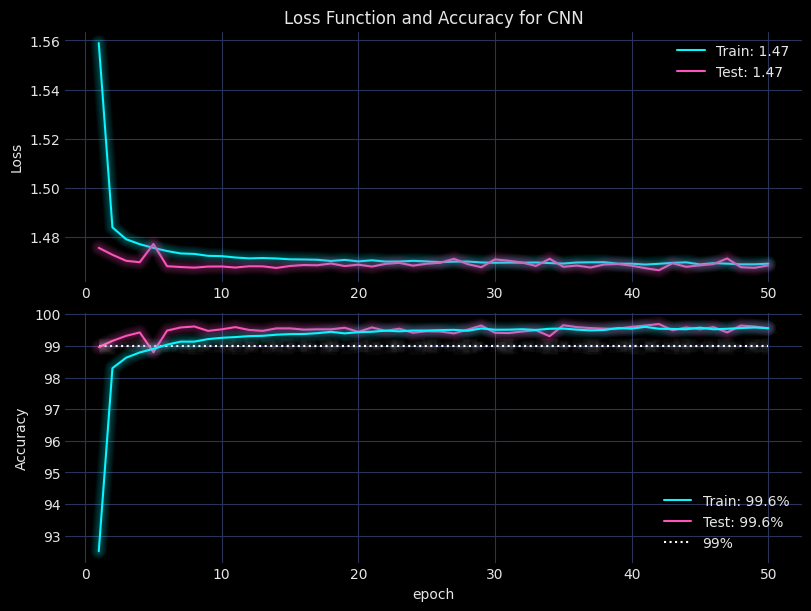

In [13]:
title = f'Loss Function and Accuracy for CNN'
plot_loss_and_accuracy(title, params.epochs, train_loss, train_acc, test_loss, test_acc);

In [14]:
miss_test_loader = DataLoader(
    test_data, batch_size=len(test_data), pin_memory=True, num_workers=params.cpu_count, shuffle=False
)
modelCNN.eval()
with torch.inference_mode():
    batch, y_labels = next(iter(miss_test_loader))
    y_preds = modelCNN(batch.to(params.device)).cpu().argmax(dim=1)
    y_eq = torch.eq(y_labels, y_preds)
    misclassified_y_idx = [idx for idx, is_equal in enumerate(y_eq) if not is_equal]

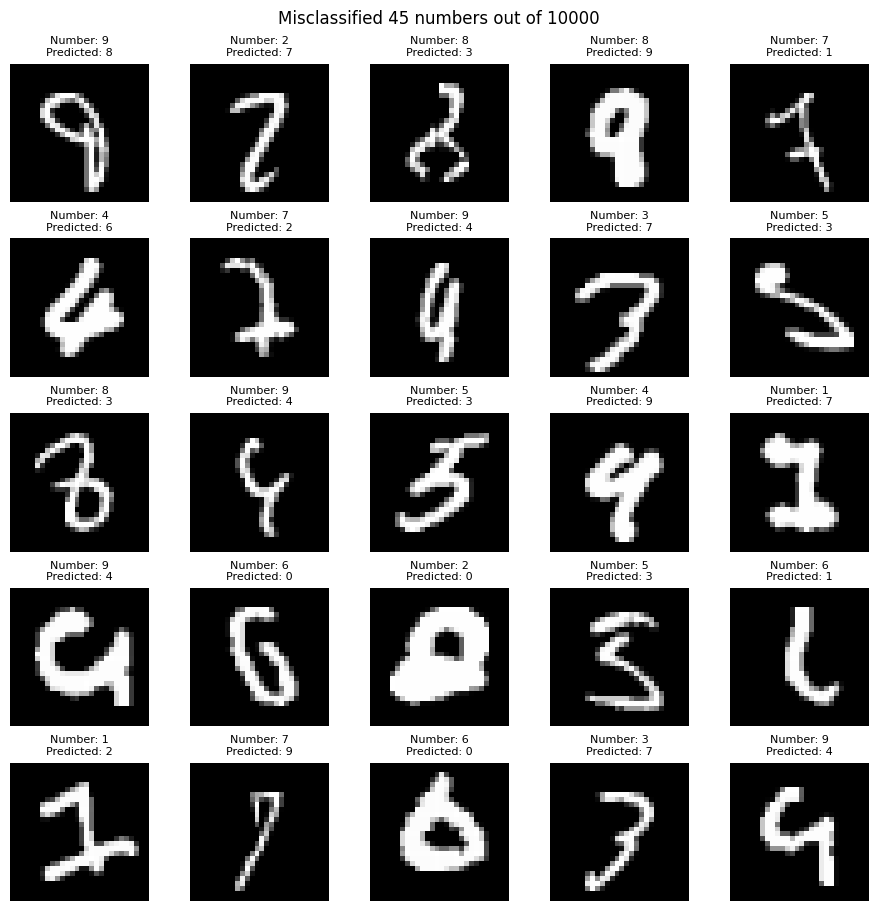

In [15]:
figure, axes = plt.subplots(5, 5, layout='constrained', figsize=(9, 9))
for index, axes in enumerate(figure.axes):
    try:
        mis_y_idx = misclassified_y_idx[index]
        axes.imshow(batch[mis_y_idx].squeeze(), cmap='gray')
        title = f'Number: {y_labels[mis_y_idx].item()}\nPredicted: {y_preds[mis_y_idx].item()}'
        axes.set_title(title, fontsize=8)
    except IndexError:
        pass
    axes.axis(False)
figure.suptitle(f'Misclassified {len(misclassified_y_idx)} numbers out of {len(batch)}');

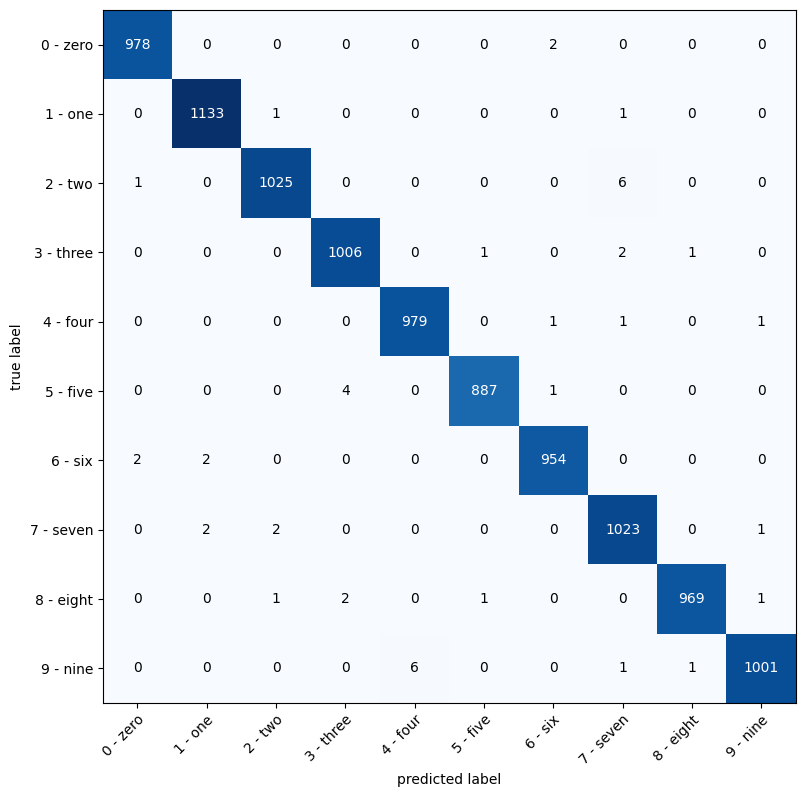

In [16]:
confusion_matrix_generator = ConfusionMatrix(task='multiclass', num_classes=len(data_classes))
confusion_matrix = confusion_matrix_generator(y_preds, target=y_labels).numpy()
figure, axes = plot_confusion_matrix(conf_mat=confusion_matrix,
                                     class_names=data_classes,
                                     figsize=(9, 9))

We can see that mostly confused labels are 7 with 1, 5 with 3 or 4 with 9